# The simple model 11
Доработанная сеть от Megnet, сравнение с моделью на элементных признаках

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

!pip install matminer
!pip install pymatgen
!pip install maml
!git clone https://github.com/bvd757/3DSC.git
!pip install megnet

from megnet.models import MEGNetModel
from megnet.data.crystal import CrystalGraph

from pymatgen.core.structure import Structure
from maml.describers import BPSymmetryFunctions

!pip install monty
from monty.json import MontyDecoder
from monty.serialization import loadfn

from megnet.data.crystal import CrystalGraph
from megnet.data.graph import GaussianDistance
from megnet.models import MEGNetModel

In [45]:
data = pd.read_csv('https://raw.githubusercontent.com/aimat-lab/3DSC/main/superconductors_3D/data/final/MP/3DSC_MP.csv', header = 1)
data1 = data.loc[data['tc'] > 0.1]
data1 = data1.loc[data['tc'] < 30.0]
data_t = np.log(data1[['tc']])
data2 = data1[['formula_sc']]

In [47]:
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.conversions import StrToComposition
ep_feat = ElementProperty.from_preset(preset_name="magpie")
d = {"element": np.array(data2)[:, 0]}
df = pd.DataFrame(d)

df = StrToComposition().featurize_dataframe(df, "element")
df = ep_feat.featurize_dataframe(df, col_id = 'composition')

StrToComposition:   0%|          | 0/3347 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/3347 [00:00<?, ?it/s]

In [ ]:
structures1 = [0] * len(df)
targets1 = [0] * len(df)
data_t1 = np.array(data_t)
l = len(df)
for i in enumerate(os.listdir(path="/content/3DSC/superconductors_3D/data/final/MP/cifs")):
    if i[0] % 100 == 0: print(i[0])
    #print("\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n", i[1], "\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n")
    if i[1][:i[1].find('-MP')] not in df['element'].to_list(): continue
    j = df.loc[df['element'] == i[1][:i[1].find('-MP')]].index
    j = j[0]
    cif = Structure.from_file("/content/3DSC/superconductors_3D/data/final/MP/cifs/" + i[1])
    structures1[j] = cif
    targets1[j] = data_t1[j]

df1 = df[['MagpieData mean AtomicWeight', 'MagpieData mean MeltingT',
'MagpieData mean Electronegativity', 'MagpieData mean NdValence', 'MagpieData mean GSvolume_pa', 'MagpieData mean SpaceGroupNumber', 'MagpieData mean NdUnfilled']]

In [ ]:
model = MEGNetModel(10, 2, nblocks=1, lr=1e-2,
                    n1=4, n2=4, n3=4, npass=1, ntarget=1,
                    graph_converter=CrystalGraph(bond_converter=GaussianDistance(np.linspace(0, 5, 10), 0.5)))
model.compile(loss='mse')

In [ ]:
from megnet.utils.models import load_model, AVAILABLE_MODELS
from pymatgen.core import Structure, Lattice
from pymatgen.ext.matproj import MPRester
print(AVAILABLE_MODELS)

In [ ]:
model = load_model('Efermi_MP_2019')
model.compile(loss='mse')

In [ ]:
structure_for_test = Structure.from_file("/content/3DSC/superconductors_3D/data/final/MP/cifs/" + 'Ag0.55Hg0.45-MP-mp-770433.cif')
A = []
B = []
for i in range(len(structures1)):
    if i % 100 == 0:
        print(i, len(B) / (i + 1))
        
    if structures1[i] == 0:
        B.append(i)
        continue

    try:
        model.train([structure_for_test, structures1[i]], [1, 1], epochs=1,  verbose = 0);
        A.append(i)
    except:
        B.append(i)

B = sorted(B, reverse = True)

In [31]:
structures2 = structures1.copy()
targets2 = targets1.copy()
df2 = df1.copy()
df2.drop(labels=B, axis=0, inplace=True)

for i in B:
    structures2.pop(i)
    targets2.pop(i)

In [50]:
df2

,MagpieData mean AtomicWeight,MagpieData mean MeltingT,MagpieData mean Electronegativity,MagpieData mean NdValence,MagpieData mean GSvolume_pa,MagpieData mean SpaceGroupNumber,MagpieData mean NdUnfilled
8,77.796450,1382.655000,1.568333,1.666667,34.138333,227.333333,0.000000
9,190.406740,1859.163333,1.555000,4.666667,26.703333,225.000000,5.333333
20,43.163400,1976.976667,2.003333,3.333333,10.225000,185.666667,0.000000
21,112.501400,698.143333,1.830000,10.000000,21.616667,167.666667,0.000000
22,123.386835,1213.965000,1.515000,5.500000,26.613750,209.500000,4.500000
...,...,...,...,...,...,...,...
3342,152.968000,3172.666667,2.016667,3.333333,18.431667,217.333333,6.666667
3343,141.879850,2784.950000,2.630000,3.000000,14.313750,174.750000,4.500000
3344,65.380000,692.680000,1.650000,10.000000,13.960000,194.000000,0.000000
3345,73.994667,1171.120000,1.543333,7.333333,17.038333,194.000000,2.666667


In [32]:
len(A)

1140

In [33]:
X_train, y_train = structures2[:50], targets2[:50]
losses = [0] * len(AVAILABLE_MODELS)
for i, model_name in enumerate(AVAILABLE_MODELS):
    model = load_model(model_name)
    model.compile(loss='mse')
    history = model.train(X_train, y_train, epochs = 5, batch_size = 10, verbose = 0, save_checkpoint = True)
    losses[i] = history.history.history['loss'][-1]
    print(model_name, history.history.history['loss'])
    print()

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Eform_MP_2019 [2.175044536590576, 1.0680592060089111, 0.6472693085670471, 0.4830528199672699, 0.34739407896995544]

Eform_MP_2018 [2.463895320892334, 1.1332095861434937, 0.5803142786026001, 0.34225302934646606, 0.22371847927570343]

Efermi_MP_2019 [2.026341199874878, 0.46811938285827637, 0.21536996960639954, 0.13981010019779205, 0.08179308474063873]

Bandgap_classifier_MP_2018 [1.961220383644104, 1.2967798709869385, 1.1514298915863037, 1.065051794052124, 0.9801561236381531]

Bandgap_MP_2018 [1.8140857219696045, 0.9265910983085632, 0.5761750936508179, 0.44422292709350586, 0.3759779930114746]

logK_MP_2018 [2.830679416656494, 2.23701810836792, 2.146714687347412, 2.0507378578186035, 1.825238823890686]

logG_MP_2018 [2.5074801445007324, 1.9504330158233643, 1.6268717050552368, 1.4473614692687988, 1.340053677558899]

logK_MP_2019 [6.992964267730713, 6.359163284301758, 5.939637660980225, 5.520193099975586, 5.4051127433776855]

logG_MP_2019 [7.755278587341309, 7.1097235679626465, 6.74447917938

In [ ]:
X_train, y_train = structures2[:800], targets2[:800] 
X_validation, y_validation = structures2[800:1000], targets2[800:1000]
history = model.train(train_structures=X_train, train_targets=y_train, validation_structures=X_validation, 
                      validation_targets=y_validation, epochs = 100, batch_size = 10, verbose = 1)
history.history.history['loss']

In [79]:
epochs = 1000
train_loss = [0] * epochs
validation_loss = [0] * epochs
X_train, y_train = structures2[:1000], targets2[:1000]
X_validation, y_validation = structures2[1000:], targets2[1000:]
model = load_model('Bandgap_MP_2018')
model.compile(loss='mse')
t = model.copy()
history = model.train(train_structures=X_train[:10], train_targets=y_train[:10], epochs = 1, batch_size = 1, verbose = 0)
b = model.get_weights()

In [ ]:
for epoch in range(epochs):
    print("epoch =", epoch + 1)
    print('train')
    if epoch != 0: model.set_weights(weights)
    history = model.train(train_structures=X_train, train_targets=y_train, epochs = 1, batch_size = 100, verbose = 1)
    train_loss[epoch] = history.history.history['loss'][-1]

    print()
    print('validation')
    weights = model.get_weights()
    weights_massive.append(weights)
    history = model.train(train_structures=X_validation, train_targets=y_validation, epochs = 1, batch_size = 100, verbose = 1)
    validation_loss[epoch] = history.history.history['loss'][-1]
    print("\n\n")

In [ ]:
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.history = {'loss':[],'val_loss':[]}

    def on_batch_end(self, batch, logs={}):
        self.history['loss'].append(logs.get('loss'))

    def on_epoch_end(self, epoch, logs={}):
        self.history['val_loss'].append(logs.get('val_loss'))

history = LossHistory()

X_train, y_train = structures2[:10], targets2[:10]
X_validation, y_validation = structures2[10:12], targets2[10:12]
model = load_model('Bandgap_MP_2018')
model.compile(loss='mse', metrics=['val_loss'])
model.train(train_structures = X_train, train_targets = y_train, 
                      validation_structures = X_validation, validation_targets = y_validation, epochs = 1, batch_size = 1, verbose = 1, validation_freq=1, callbacks=[history])

In [133]:
history.val_losses

[None, None, None, None, None, None, None, None, None, None]

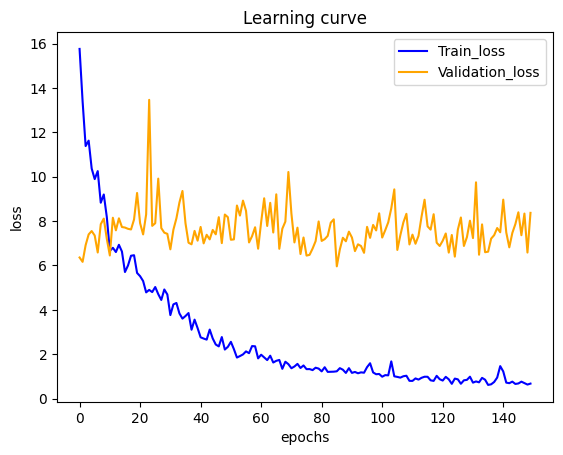

In [52]:
fig, ax = plt.subplots()
ax.grid()
plt.grid()
plt.plot(np.arange(epochs), train_loss, color = 'blue', label = "Train_loss")
plt.plot(np.arange(epochs), validation_loss, color = 'orange', label = "Validation_loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Learning curve")
#plt.ylim((0, 4))
plt.legend()
plt.show()

In [ ]:
X_train, y_train = structures2[:1000], targets2[:1000]
X_test, y_test = structures2[1000:], targets2[1000:]
model = load_model('Efermi_MP_2019')
model.compile(loss='mse')
history = model.train(train_structures=X_train, train_targets=y_train, epochs = 500, batch_size = 10, verbose = 1)
history.history.history['loss']

In [ ]:
predictions_g1 = np.zeros(len(X_train))
for i in range(len(X_train)):
    print(i)
    predictions_g1[i] = model.predict_structure(X_train[i]).ravel()

In [ ]:
predictions_g = np.zeros(len(X_test))
for i in range(len(X_test)):
    print(i)
    predictions_g[i] = model.predict_structure(X_test[i]).ravel()

In [54]:
train_loss = ((predictions_g1 - y_train) ** 2).sum()
test_loss = ((predictions_g - y_test) ** 2).sum()
print(train_loss)
print(test_loss)

2248171.900533854
32820.24547467067


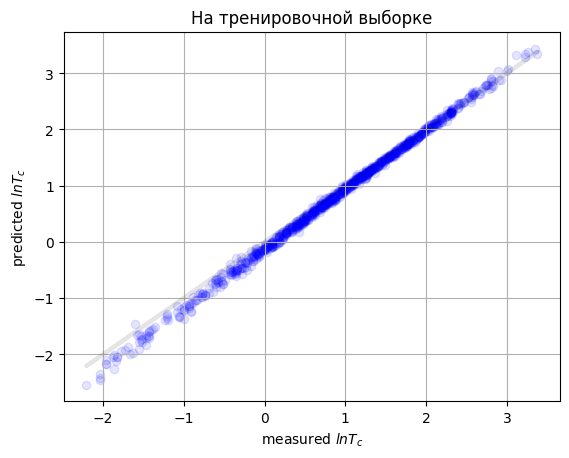

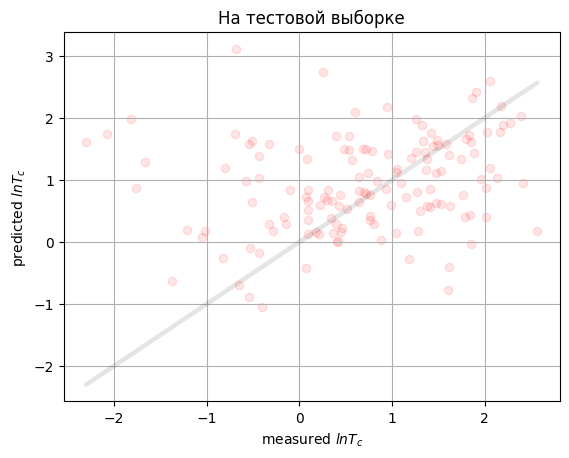

In [43]:
fig, ax = plt.subplots()
ax.grid()


plt.scatter(y_train, predictions_g1, color = 'blue', alpha = 0.1)
plt.plot(y_train, y_train, color = 'black', linewidth = 3, alpha = 0.1)
ax.set_xlabel('measured $ln T_c$')
ax.set_ylabel('predicted $ln T_c$')
plt.title("На тренировочной выборке")
#plt.ylim((0, 4))
plt.show()

plt.grid()
plt.scatter(y_test, predictions_g, color = 'red', alpha = 0.1)
plt.plot(y_test, y_test, color = 'black', linewidth = 3, alpha = 0.1)
plt.xlabel('measured $ln T_c$')
plt.ylabel('predicted $ln T_c$')
plt.title("На тестовой выборке")
#plt.ylim((0, 4))
plt.show()

In [ ]:
X_train, y_train = df2[:1000], targets2[:1000]
X_test, y_test = df2[1000:], targets2[1000:]

param_grid = { 
            "n_estimators"      : [30, 100, 300],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,8],
            "bootstrap": [True, False],
            }
rfr = RandomForestRegressor()
CV_rfr = GridSearchCV(estimator = rfr, param_grid = param_grid, cv = 5)
CV_rfr.fit(X_train, y_train)

In [58]:
CV_rfr.best_params_

{'bootstrap': True,
 'max_features': 'sqrt',
 'min_samples_split': 4,
 'n_estimators': 300}

In [59]:
rfr1 = RandomForestRegressor(max_features = 'sqrt', min_samples_split = 4, bootstrap = True, n_estimators = 100)
rfr1.fit(X_train, y_train)
predictions = rfr1.predict(X_test)
predictions1 = rfr1.predict(X_train)

<ipython-input-59-99f208eecd92>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr1.fit(X_train, y_train)


In [60]:
train_loss = ((predictions1 - y_train) ** 2).sum()
test_loss = ((predictions - y_test) ** 2).sum()
print(train_loss)
print(test_loss)

1545683.924147896
24526.622424673278


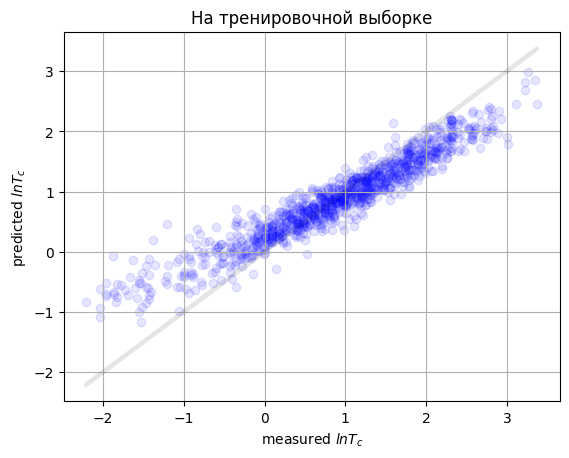

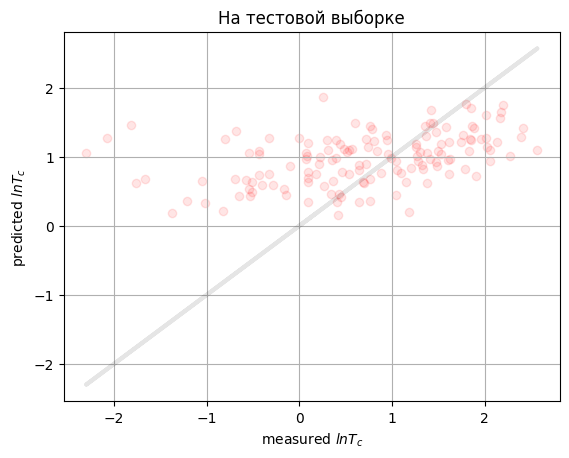

In [61]:
fig, ax = plt.subplots()
ax.grid()


plt.scatter(y_train, predictions1, color = 'blue', alpha = 0.1)
plt.plot(y_train, y_train, color = 'black', linewidth = 3, alpha = 0.1)
ax.set_xlabel('measured $ln T_c$')
ax.set_ylabel('predicted $ln T_c$')
plt.title("На тренировочной выборке")
#plt.ylim((0, 4))
plt.show()

plt.grid()
plt.scatter(y_test, predictions, color = 'red', alpha = 0.1)
plt.plot(y_test, y_test, color = 'black', linewidth = 3, alpha = 0.1)
plt.xlabel('measured $ln T_c$')
plt.ylabel('predicted $ln T_c$')
plt.title("На тестовой выборке")
#plt.ylim((0, 4))
plt.show()